# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

<h3 style="color:Brown">Business Understanding</h3> 
From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

---

<h4 style="color:Blue">Definition</h4> 
Given a quantity of data (426000 records) with information on the variables of a vehicle (displacement, odometer, model, etc.) and given the selling price of the vehicle, we will determine, using the appropriate tools(k-means, linear regression, etc), which features (phi) have the most weight at the time of predicting the values. For this task we have several tools that allow us to glimpse more clearly the objective we are looking for.

The objectives are as follows:
<ul>
    <li>Find the features(phi) that most influence price.</li>
    <li>To find the best model to predict the price of vehicles.</li>
</ul>


<h3 style="color:Brown">Data Understanding</h3> 

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

---

<h4 style="color:Blue">Definition</h4> 

In the following lines we are going to analyze the dataset data in order to define the quality of the data and verify that we need to be able to use it reliably in a complete model.

Loading libs

In [1]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, make_column_selector
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer, KNNImputer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import plotly.express as px
import warnings
from scipy.special import exp10
from scipy import stats
from sklearn.metrics import r2_score
from scipy.sparse import csr_matrix
from category_encoders import TargetEncoder

In [2]:
warnings.filterwarnings('ignore')

Loading my Dataset and analyzing data

In [3]:
vehicles = pd.read_csv('data/vehicles.csv')

In [4]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [5]:
vehicles.head()

id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN    az  
1  NaN  NaN         NaN    ar  
2  NaN  NaN         NaN    fl  
3  NaN  NaN         NaN    ma  
4  NaN  NaN         NaN    nc

There are many null values inside the dataset, among them some of the records have almost no information and some others do not report some of their characteristics. Next we verify the number of null values we have

In [6]:
veh_null = vehicles.isnull().sum().sort_values().reset_index()
veh_null.columns = ['Feature', 'Count']
veh_null['%'] = round(veh_null['Count'] / len(vehicles)* 100, 2 )
veh_null


Feature   Count      %
0             id       0   0.00
1          price       0   0.00
2          state       0   0.00
3         region       0   0.00
4           year    1205   0.28
5   transmission    2556   0.60
6           fuel    3013   0.71
7       odometer    4400   1.03
8          model    5277   1.24
9   title_status    8242   1.93
10  manufacturer   17646   4.13
11          type   92858  21.75
12   paint_color  130203  30.50
13         drive  130567  30.59
14           VIN  161042  37.73
15     condition  174104  40.79
16     cylinders  177678  41.62
17          size  306361  71.77

Text(0, 0.5, '% Null')

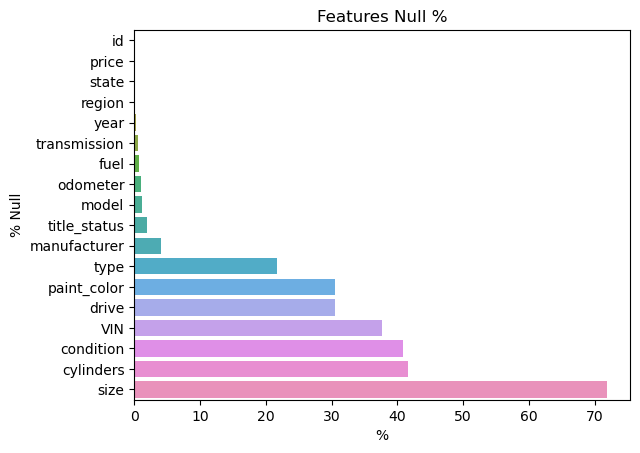

In [7]:
sns.barplot(data = veh_null, y = 'Feature', x = '%')
plt.title('Features Null %')
plt.xticks(rotation=0)
plt.ylabel('% Null')

Many of the numeric columns can be replaced with an average (such as the year) and some of the categorical columns, such as transmission, can be replaced with the most frequent value, below is a column by column analysis.

<span style="text-decoration:underline">id</span>: we can use this column as an index or we can drop this column, i choose drop it<br/>
<span style="text-decoration:underline">price</span>: target variable, some prices have a value of 0, these zeros will be replaced by the mean. <br/>
<span style="text-decoration:underline">state</span>: categorical variable without null values<br/>
<span style="text-decoration:underline">region</span>: categorical variable without null values.<br/>
<span style="text-decoration:underline">year</span>: we can reeplace values using the most frequently value<br/>
<span style="text-decoration:underline">transmission</span>: we can replace the nulls with the value 'other'<br/>
<span style="text-decoration:underline">fuel</span>: we can replace the nulls with the value 'other'.<br/>
<span style="text-decoration:underline">odometer</span>: we can average the values of all vehicles and assign this average to the null values<br/>
<span style="text-decoration:underline">model</span>: This feature has too many categorical values, the idea here is to eliminate the null values once we have imputed the rest of the features.<br/>
<span style="text-decoration:underline">title_status</span>: we can reeplace values using the most frequently value<br/>
<span style="text-decoration:underline">manufacturer</span>: This column has a significant amount of null values, but I think it is possible to use the most frequently used value<br/>
<span style="text-decoration:underline">type</span>: This column is important but has almost 22% of null values, we can replace the nulls with the value 'other'<br/>
<span style="text-decoration:underline">paint_color</span>: we can reeplace values using the most frequently value<br/>
<span style="text-decoration:underline">drive</span>: This column is important but has almost 30% of null values, we will apply the most frequent value as long as it does not exceed 50% of null values<br/>
<span style="text-decoration:underline">VIN</span>: this column is a unique identifier and can be dropped<br/>
<span style="text-decoration:underline">condition</span>: we will apply the most frequent value<br/>
<span style="text-decoration:underline">cylinders</span>: First at all it is possible to convert this column to numerical. Second, approximately 41% of the values are null, almost 50%. I will take the risk to impute them with the most frequent value<br/>
<span style="text-decoration:underline">size</span>: size is a value that has almost no useful values since the nulls represent 71% (> 50% null values) of the total dataset, this column should be dropped<br/>

There are some records that are not really worth saving and they are all those that only have the price of the vehicle and no other data (except for the state and region), these data will be removed from the datset.

now, let's check all the categorical columns in order to identify them well.

In [8]:
cats = ['state', 'region', 'transmission', 'fuel', 'model', 'title_status', 'manufacturer', 'type', 'paint_color', 'drive', 'condition', 'cylinders']
for cat in cats:
    temp_cat_df = vehicles[cat].value_counts().reset_index().sort_values(by = 'count', ascending = False)
    display(temp_cat_df)

state  count
0     ca  50614
1     fl  28511
2     tx  22945
3     ny  19386
4     oh  17696
5     or  17104
6     mi  16900
7     nc  15277
8     wa  13861
9     pa  13753
10    wi  11398
11    co  11088
12    tn  11066
13    va  10732
14    il  10387
15    nj   9742
16    id   8961
17    az   8679
18    ia   8632
19    ma   8174
20    mn   7716
21    ga   7003
22    ok   6792
23    sc   6327
24    mt   6294
25    ks   6209
26    in   5704
27    ct   5188
28    al   4955
29    md   4778
30    nm   4425
31    mo   4293
32    ky   4149
33    ar   4038
34    ak   3474
35    la   3196
36    nv   3194
37    nh   2981
38    dc   2970
39    me   2966
40    hi   2964
41    vt   2513
42    ri   2320
43    sd   1302
44    ut   1150
45    wv   1052
46    ne   1036
47    ms   1016
48    de    949
49    wy    610
50    nd    410

region  count
0                   columbus   3608
1               jacksonville   3562
2    spokane / coeur d'alene   2988
3                     eugene   2985
4            fresno / madera   2983
..                       ...    ...
399                 meridian     28
400             southwest MS     14
401              kansas city     11
402           fort smith, AR      9
403      west virginia (old)      8

[404 rows x 2 columns]

transmission   count
0    automatic  336524
1        other   62682
2       manual   25118

fuel   count
0       gas  356209
1     other   30728
2    diesel   30062
3    hybrid    5170
4  electric    1698

model  count
0                          f-150   8009
1                 silverado 1500   5140
2                           1500   4211
3                          camry   3135
4                      silverado   3023
...                          ...    ...
19459          cr-v lx automatic      1
19460  tacoma double cab trd 4x4      1
19461      avenger r/t 4dr sedan      1
19462           yukon xl slt suv      1
29648    Paige Glenbrook Touring      1

[29649 rows x 2 columns]

title_status   count
0        clean  405117
1      rebuilt    7219
2      salvage    3868
3         lien    1422
4      missing     814
5   parts only     198

manufacturer  count
0              ford  70985
1         chevrolet  55064
2            toyota  34202
3             honda  21269
4            nissan  19067
5              jeep  19014
6               ram  18342
7               gmc  16785
8               bmw  14699
9             dodge  13707
10    mercedes-benz  11817
11          hyundai  10338
12           subaru   9495
13       volkswagen   9345
14              kia   8457
15            lexus   8200
16             audi   7573
17         cadillac   6953
18         chrysler   6031
19            acura   5978
20            buick   5501
21            mazda   5427
22         infiniti   4802
23          lincoln   4220
24            volvo   3374
25       mitsubishi   3292
26             mini   2376
27          pontiac   2288
28            rover   2113
29           jaguar   1946
30          porsche   1384
31          mercury   1184
32           saturn   1090
33       alfa-romeo    897
34            tesla    868
35             fiat    792
36  harley-davidson    153
37          ferrari     95
38           datsun     63
39     aston-martin     24
40       land rover     21
41           morgan      3

type  count
0         sedan  87056
1           SUV  77284
2        pickup  43510
3         truck  35279
4         other  22110
5         coupe  19204
6     hatchback  16598
7         wagon  10751
8           van   8548
9   convertible   7731
10     mini-van   4825
11      offroad    609
12          bus    517

paint_color  count
0        white  79285
1        black  62861
2       silver  42970
3         blue  31223
4          red  30473
5         grey  24416
6        green   7343
7       custom   6700
8        brown   6593
9       yellow   2142
10      orange   1984
11      purple    687

drive   count
0   4wd  131904
1   fwd  105517
2   rwd   58892

condition   count
0       good  121456
1  excellent  101467
2   like new   21178
3       fair    6769
4        new    1305
5    salvage     601

cylinders  count
0   6 cylinders  94169
1   4 cylinders  77642
2   8 cylinders  72062
3   5 cylinders   1712
4  10 cylinders   1455
5         other   1298
6   3 cylinders    655
7  12 cylinders    209

Many of the data have null problems and some values of the target variable have strange values such as 0 and 1 which must be removed as they are unrealistic.

Next we need to check out our target variable 

In [9]:
price_me = vehicles['price'].mean()

In [10]:
price_df = vehicles['price'].replace(0, price_me).replace(1, price_me).to_frame()
price_df

price
0        6000.0
1       11900.0
2       21000.0
3        1500.0
4        4900.0
...         ...
426875  23590.0
426876  30590.0
426877  34990.0
426878  28990.0
426879  30590.0

[426880 rows x 1 columns]

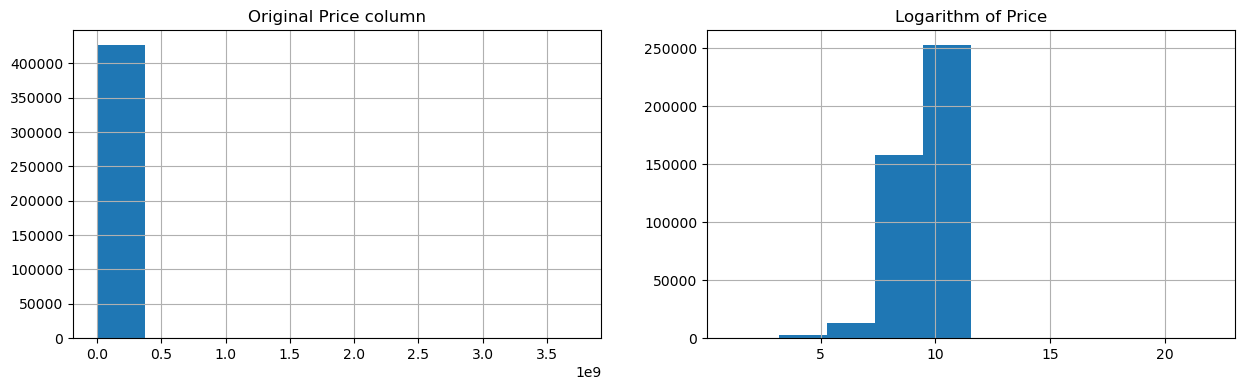

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].hist(price_df[['price']])
ax[0].grid()
ax[0].set_title('Original Price column')
ax[1].hist(np.log1p(price_df['price']))
ax[1].grid()
ax[1].set_title('Logarithm of Price');

As we can see our target variable is somewhat skewed so we will proceed to apply a logarithmic transformation method later on if required.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

___

<h4 style="color:Blue">Definition</h4> 

Once we have identified the problems in the dataset we proceed to correct them in order to have good quality data.

<h4 style="color:Blue">Imputing and Cleaning</h4>

Let's start applying the imputer for some features

In [12]:
veh_null = vehicles.isnull().sum().sort_values().reset_index()
veh_null.columns = ['Feature', 'Count']
veh_null['%'] = round(veh_null['Count'] / len(vehicles)* 100, 2 )
veh_null

Feature   Count      %
0             id       0   0.00
1          price       0   0.00
2          state       0   0.00
3         region       0   0.00
4           year    1205   0.28
5   transmission    2556   0.60
6           fuel    3013   0.71
7       odometer    4400   1.03
8          model    5277   1.24
9   title_status    8242   1.93
10  manufacturer   17646   4.13
11          type   92858  21.75
12   paint_color  130203  30.50
13         drive  130567  30.59
14           VIN  161042  37.73
15     condition  174104  40.79
16     cylinders  177678  41.62
17          size  306361  71.77

In [430]:
#Copying the data
vehicles_clean = vehicles.copy()

#Dropping useless features, outliers
vehicles_clean['price'] = vehicles_clean['price'].astype('int64')

#zscore
vehicles_clean['z_score'] = stats.zscore(vehicles_clean['price'])
zcore_index = vehicles_clean.loc[(vehicles_clean['z_score'] > 0.1)].index
vehicles_clean = vehicles_clean.drop(zcore_index)
vehicles_clean = vehicles_clean.drop(['z_score'], axis = 1)
#IQR
q1 = vehicles_clean['price'].quantile(0.25)
q3 = vehicles_clean['price'].quantile(0.75)
iqr = q3 - q1
low_lim = q1 - 0.27 * iqr
upper_lim = q3 + 2.5 * iqr
iqr_index = vehicles_clean[(vehicles_clean['price'] < low_lim) | (vehicles_clean['price'] > upper_lim)].index
vehicles_clean = vehicles_clean.drop(iqr_index)

vehicles_clean = vehicles_clean.drop(['VIN', 'size', 'id'], axis = 1)
vehicles_clean = vehicles_clean.reset_index(drop = True)

#imputing the data
imputer_trans = make_column_transformer(
    (SimpleImputer(missing_values = np.nan, strategy='mean'), ['odometer']),
    (SimpleImputer(missing_values = np.nan, strategy='most_frequent'), ['year','cylinders'])
)

vehicles_clean['cylinders'] = vehicles_clean['cylinders'].str.replace(' cylinders', '').str.replace('other', '6').str.strip()
temp_imp_cols = pd.DataFrame(imputer_trans.fit_transform(vehicles_clean), columns = ['odometer', 'year', 'cylinders'])

vehicles_clean['odometer'] = temp_imp_cols['odometer'].astype('int64')
vehicles_clean['year'] = temp_imp_cols['year']
vehicles_clean['year'] = vehicles_clean['year'].astype('int32')
vehicles_clean['transmission'] = vehicles_clean['transmission'].fillna(vehicles_clean["transmission"].mode()[0])
vehicles_clean['fuel'] = vehicles_clean['fuel'].fillna(vehicles_clean["fuel"].mode()[0])
vehicles_clean['title_status'] = vehicles_clean['title_status'].fillna(vehicles_clean["title_status"].mode()[0])
vehicles_clean['manufacturer'] = vehicles_clean['manufacturer'].fillna(vehicles_clean["manufacturer"].mode()[0])
vehicles_clean['type'] = vehicles_clean['type'].fillna(vehicles_clean["type"].mode()[0])
vehicles_clean['paint_color'] = vehicles_clean['paint_color'].fillna(vehicles_clean["paint_color"].mode()[0])
vehicles_clean['drive'] = vehicles_clean['drive'].fillna(vehicles_clean["drive"].mode()[0])
vehicles_clean['condition'] = vehicles_clean['condition'].fillna(vehicles_clean["condition"].mode()[0])
vehicles_clean['cylinders'] =  temp_imp_cols['cylinders'].astype('int32')

#Dropping null data
vehicles_clean = vehicles_clean.dropna()

display(vehicles_clean)

region  price  year manufacturer                     model  \
22       auburn  33590  2014          gmc  sierra 1500 crew cab slt   
23       auburn  22590  2010    chevrolet            silverado 1500   
24       auburn  39590  2020    chevrolet       silverado 1500 crew   
25       auburn  30990  2017       toyota      tundra double cab sr   
26       auburn  15000  2013         ford                 f-150 xlt   
...         ...    ...   ...          ...                       ...   
384508  wyoming  23590  2019       nissan         maxima s sedan 4d   
384509  wyoming  30590  2020        volvo  s60 t5 momentum sedan 4d   
384510  wyoming  34990  2020     cadillac          xt4 sport suv 4d   
384511  wyoming  28990  2018        lexus           es 350 sedan 4d   
384512  wyoming  30590  2019          bmw  4 series 430i gran coupe   

        condition  cylinders    fuel  odometer title_status transmission  \
22           good          8     gas     57923        clean        other   
23           good          8     gas     71229        clean        other   
24           good          8     gas     19160        clean        other   
25           good          8     gas     41124        clean        other   
26      excellent          6     gas    128000        clean    automatic   
...           ...        ...     ...       ...          ...          ...   
384508       good          6     gas     32226        clean        other   
384509       good          6     gas     12029        clean        other   
384510       good          6  diesel      4174        clean        other   
384511       good          6     gas     30112        clean        other   
384512       good          6     gas     22716        clean        other   

       drive       type paint_color state  
22       4wd     pickup       white    al  
23       4wd     pickup        blue    al  
24       4wd     pickup         red    al  
25       4wd     pickup         red    al  
26       rwd      truck       black    al  
...      ...        ...         ...   ...  
384508   fwd      sedan       white    wy  
384509   fwd      sedan         red    wy  
384510   4wd  hatchback       white    wy  
384511   fwd      sedan      silver    wy  
384512   rwd      coupe       white    wy  

[380122 rows x 15 columns]

Let's detect duplicates values and remove them

In [431]:
vehicles_clean.duplicated().value_counts()

False    333514
True      46608
Name: count, dtype: int64

In [432]:
vehicles_clean = vehicles_clean.drop_duplicates()

In [433]:
vehicles_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333514 entries, 22 to 384512
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   region        333514 non-null  object
 1   price         333514 non-null  int64 
 2   year          333514 non-null  int32 
 3   manufacturer  333514 non-null  object
 4   model         333514 non-null  object
 5   condition     333514 non-null  object
 6   cylinders     333514 non-null  int32 
 7   fuel          333514 non-null  object
 8   odometer      333514 non-null  int64 
 9   title_status  333514 non-null  object
 10  transmission  333514 non-null  object
 11  drive         333514 non-null  object
 12  type          333514 non-null  object
 13  paint_color   333514 non-null  object
 14  state         333514 non-null  object
dtypes: int32(2), int64(2), object(11)
memory usage: 38.2+ MB


Here we check for null values

In [434]:
veh_null = vehicles_clean.isnull().sum().sort_values().reset_index()
veh_null.columns = ['Feature', 'Count']
veh_null['%'] = round(veh_null['Count'] / len(vehicles_clean)* 100, 2 )
veh_null

Feature  Count    %
0         region      0  0.0
1          price      0  0.0
2           year      0  0.0
3   manufacturer      0  0.0
4          model      0  0.0
5      condition      0  0.0
6      cylinders      0  0.0
7           fuel      0  0.0
8       odometer      0  0.0
9   title_status      0  0.0
10  transmission      0  0.0
11         drive      0  0.0
12          type      0  0.0
13   paint_color      0  0.0
14         state      0  0.0

<h4 style="color:Blue">Correlations</h4>

Now we need to plot the correlations between numerical variables. The idea is to verify if any feature has a correlation with another in order to eliminate it.

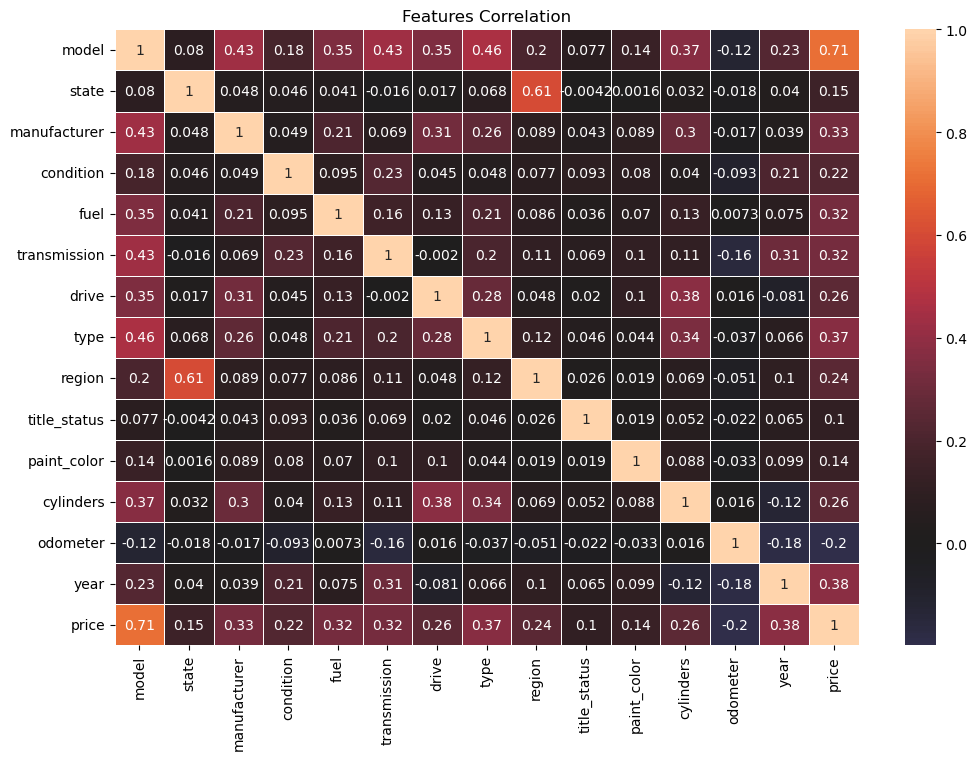

In [435]:
#sns.pairplot(vehicles_clean[['price', 'cylinders', 'odometer', 'year']], kind="reg", diag_kind="kde")

cats = ['model' , 'state', 'manufacturer', 'condition', 'fuel', 'transmission', 'drive', 'type', 'region', 'title_status', 'paint_color']
trg_enc = TargetEncoder()
vehicle_corr = pd.concat([trg_enc.fit_transform(vehicles_clean[cats] , vehicles_clean["price"]), vehicles_clean[['cylinders', 'odometer', 'year', 'price']]], axis = 1).corr()

sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(vehicle_corr, center = 0, linewidth = .5, annot = True).set(title='Features Correlation');


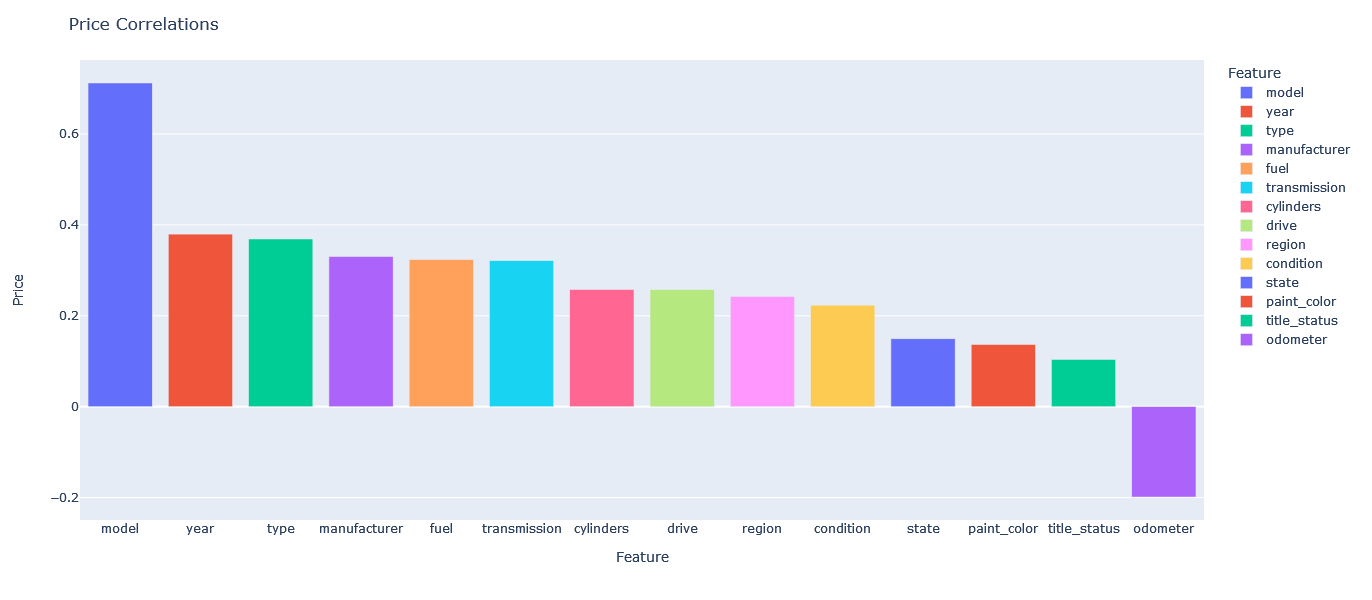

In [436]:
vehicle_corr_price = vehicle_corr[['price']].sort_values(by = 'price', ascending = False).reset_index()
fig = px.bar(vehicle_corr_price[1:], x = 'index', y = 'price', color='index', labels={'price':'Price', 'index' : 'Feature'})
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title="Price Correlations"
)

fig.show()

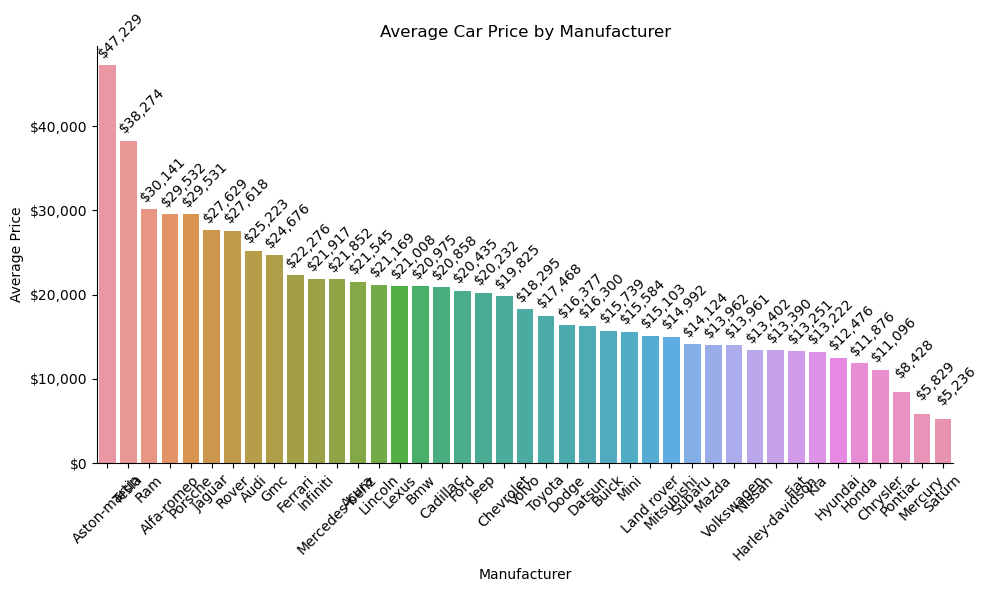

<Figure size 640x480 with 0 Axes>

In [438]:
average_price_per_manufacturer = vehicles_clean.groupby('manufacturer')['price'].mean().reset_index()

# Sort the manufacturers by average price in descending order
average_price_per_manufacturer_sorted = average_price_per_manufacturer.sort_values(by='price', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
ax = sns.barplot(data=average_price_per_manufacturer_sorted, x='manufacturer', y='price')
plt.title('Average Car Price by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

# Get current axis tick labels
xlabels = [label.get_text() for label in plt.gca().get_xticklabels()]
ylabels = [label.get_text() for label in plt.gca().get_yticklabels()]


# Format each number with commas and a dollar sign
y_formatted_numbers = [f'${int(num):,.0f}' for num in ylabels]

# Format each number with commas separating the thousands
#_formatted_numbers = ['{:,}'.format(int(num)) for num in xlabels]

# Format each number with commas and a dollar sign
y_formatted_numbers = [f'${int(num):,.0f}' for num in ylabels]

# Capitalize each label
capitalized_labels = [label.capitalize() for label in xlabels]

# Set the modified labels back on the x-axis
plt.gca().set_xticklabels(capitalized_labels)
plt.gca().set_yticklabels(y_formatted_numbers)

plt.xticks(rotation=45)  # Optional: Rotate labels to avoid overlap

# Annotate each bar with the value
for p in ax.patches:
    ax.annotate('${:,.0f}'.format(p.get_height()),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'top',
    xytext = (10, 40),
    textcoords = 'offset points',
    rotation=45)


# Despine the plot and show the final result
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig("Average Car Price by Manufacturer.png", dpi=300)

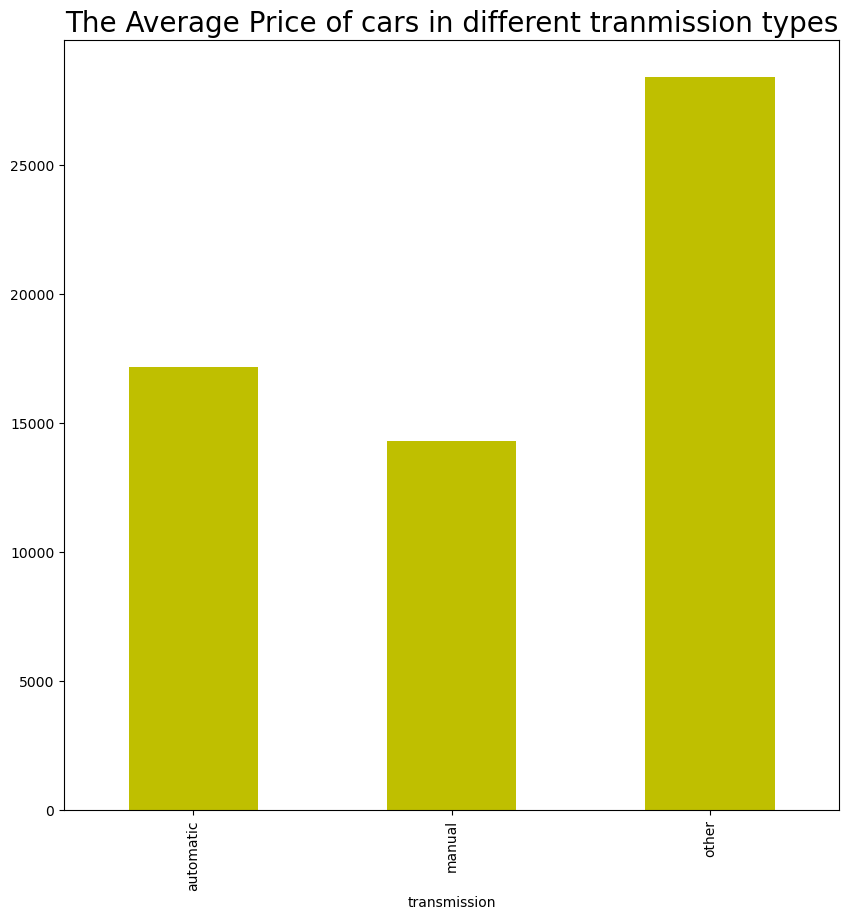

In [439]:
plt.figure(figsize = (10, 10))
vehicles_clean.groupby('transmission')['price'].mean().plot(kind = 'bar', color = 'y')
plt.title("The Average Price of cars in different tranmission types", fontsize = 20)
plt.show()

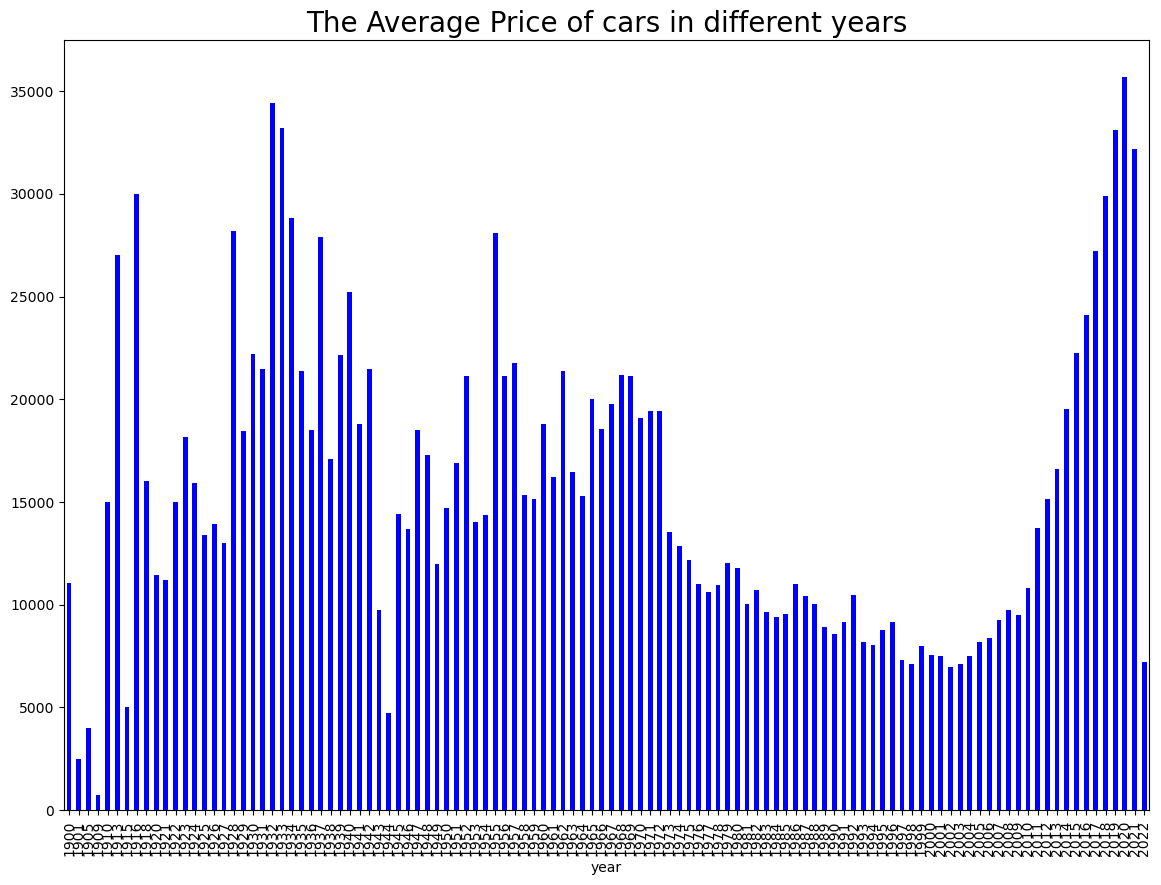

In [440]:
plt.figure(figsize = (14, 10))
vehicles_clean.groupby('year')['price'].mean().plot(kind = 'bar', color = 'b')
plt.title("The Average Price of cars in different years", fontsize = 20)
plt.show()

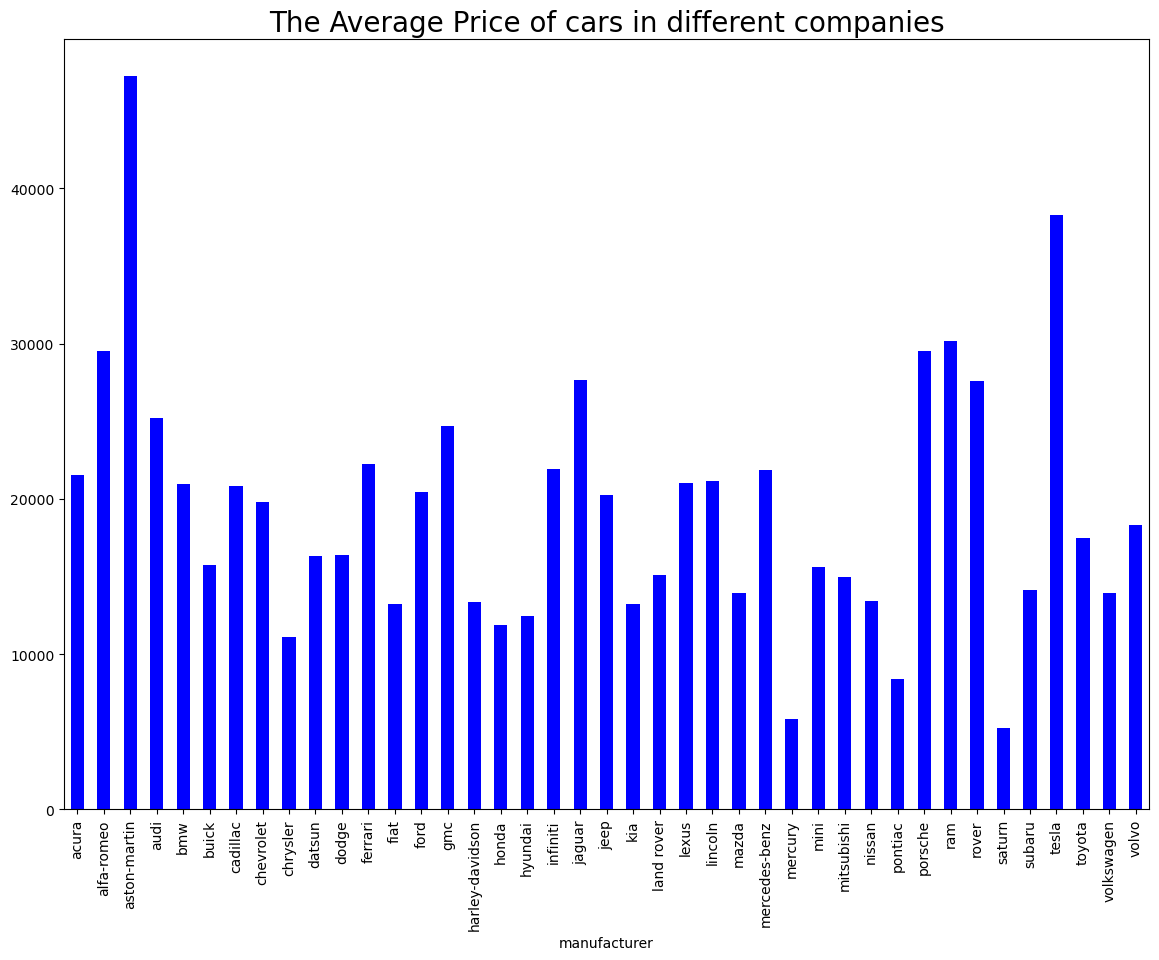

In [441]:
plt.figure(figsize = (14, 10))
vehicles_clean.groupby('manufacturer')['price'].mean().plot(kind = 'bar', color = 'b')
plt.title("The Average Price of cars in different companies", fontsize = 20)
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

___

<h4 style="color:Blue">Definition</h4> 

Once we have our data ready, we proceed to search for the best model, using Ridge, Lasso, LinearRegression and GridSearch to find the best possible model.

<h4 style="color:Blue">Splitting</h4>

In [442]:
X = vehicles_clean.drop(['price'], axis = 1)
y = vehicles_clean['price']

In [443]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
X_train

region  year manufacturer                       model  \
140306          cedar rapids  2013         fiat                  500 lounge   
74079             eastern CT  2018         jeep  wrangler unlimited all new   
343043           san antonio  2017       toyota         highlander le sport   
148985       kansas city, MO  2012        honda                        cr-v   
313024  greenville / upstate  1991          gmc        sierra 1500 long bed   
...                      ...   ...          ...                         ...   
165208             baltimore  2009       nissan                altima coupe   
132801          st louis, MO  2020          bmw                          m4   
365857     olympic peninsula  2018    chevrolet              silverado 1500   
368089        seattle-tacoma  2007         jeep  wrangler unlimited rubicon   
337316               houston  2016         ford                       f-250   

        condition  cylinders   fuel  odometer title_status transmission drive  \
140306  excellent          4    gas     67000        clean    automatic   fwd   
74079        good          6  other     13992        clean        other   4wd   
343043       good          6  other     23734        clean        other   4wd   
148985  excellent          4    gas    158380        clean    automatic   fwd   
313024  excellent          6    gas    125000        clean       manual   rwd   
...           ...        ...    ...       ...          ...          ...   ...   
165208       good          6    gas    124000        clean    automatic   fwd   
132801       good          6    gas      4013        clean    automatic   rwd   
365857       good          8    gas     33153        clean    automatic   4wd   
368089  excellent          6    gas     56942        clean    automatic   4wd   
337316       good          6  other    186890        clean    automatic   4wd   

               type paint_color state  
140306    hatchback       black    ia  
74079         other       white    ct  
343043        other       white    tx  
148985          SUV        grey    ks  
313024       pickup      silver    sc  
...             ...         ...   ...  
165208        sedan         red    md  
132801  convertible       white    il  
365857        truck       white    wa  
368089      offroad       black    wa  
337316       pickup       white    tx  

[233459 rows x 14 columns]

In [444]:
y_train

140306     6200
74079     34990
343043    30590
148985     9800
313024     5590
          ...  
165208    10500
132801    76128
365857    37999
368089    38000
337316    35495
Name: price, Length: 233459, dtype: int64

<h4 style="color:Blue">Models</h4>

In this section we start the search for the best model

In [445]:
results = pd.DataFrame({'Model': [], 'MSE Training': [], 'MSE Dev': [], 'R2 Training': [], 'R2 Dev' : [], 'Degree': [], 'Alpha': [], 'Features': [] })
results

Empty DataFrame
Columns: [Model, MSE Training, MSE Dev, R2 Training, R2 Dev, Degree, Alpha, Features]
Index: []

<h4 style="color:Green">Simple Linear Regression</h4>

<label style="color:Purple">Model pipeline</label>

In [446]:
cats = ['model' , 'state', 'manufacturer', 'condition', 'fuel', 'transmission', 'drive', 'type', 'region', 'title_status', 'paint_color']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

linear_pipe = Pipeline(
    [
        ('transf', transf),
        ('stdscl', StandardScaler()),
        ('model', LinearRegression())
        #('regressor', TransformedTargetRegressor(regressor = Ridge(), func=np.log10, inverse_func=exp10))
    ])
linear_pipe

Pipeline(steps=[('transf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['model', 'state',
                                                   'manufacturer', 'condition',
                                                   'fuel', 'transmission',
                                                   'drive', 'type', 'region',
                                                   'title_status',
                                                   'paint_color'])])),
                ('stdscl', StandardScaler()), ('model', LinearRegression())])

<label style="color:Purple">Model Fitting</label>

In [447]:
linear_pipe.fit(X_train, y_train)

Pipeline(steps=[('transf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['model', 'state',
                                                   'manufacturer', 'condition',
                                                   'fuel', 'transmission',
                                                   'drive', 'type', 'region',
                                                   'title_status',
                                                   'paint_color'])])),
                ('stdscl', StandardScaler()), ('model', LinearRegression())])

<label style="color:Purple">Model Error</label>

In [448]:
y_train_predict = linear_pipe.predict(X_train).astype(int)
y_test_predict = linear_pipe.predict(X_test).astype(int)

train_mse = mean_squared_error(y_train, y_train_predict)
test_mse = mean_squared_error(y_test, y_test_predict)
train_r2 = r2_score(y_train, y_train_predict)
test_r2 = r2_score(y_test, y_test_predict)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

results = pd.concat([
    results, pd.DataFrame({
        'Model':'Linear Regression', 
        'MSE Training': train_mse, 
        'MSE Dev': test_mse,
        'R2 Training': train_r2,
        'R2 Dev': test_r2,
        'Degree': 'NA', 
        'Alpha': 'NA', 
        'Features': 'All'
    }, index=[0])])

Train MSE: 80364167.0751481
Test MSE: 83700977.44425566
Train R2: 0.5799486403451954
Test R2: 0.5641558215943269


<label style="color:Purple">Prediction Plot</label>

Pred   Real
0       26185  27600
1       23500  18988
2       24829  29995
3        2939   4200
4        1769   3300
...       ...    ...
100050  12440    800
100051  30467  34888
100052  18692   4750
100053  16588   6900
100054  18511   6500

[100055 rows x 2 columns]

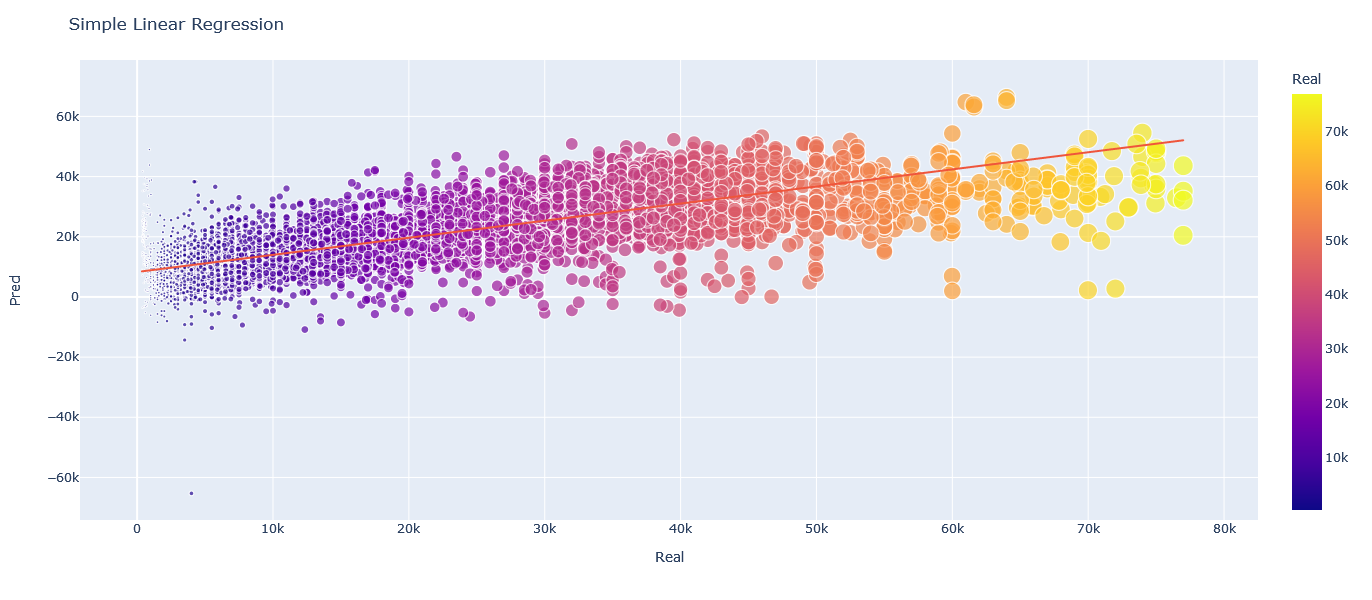

In [449]:
plot_df = pd.concat([
    pd.DataFrame(y_test_predict.reshape(len(y_test_predict), 1), 
                 columns = ['Pred']), 
    pd.DataFrame({'Real':y_test}).reset_index().drop('index', axis = 1)])

pred_df = pd.DataFrame(y_test_predict.reshape(len(y_test_predict), 1), columns = ['Pred'])
real_df = pd.DataFrame({'Real':y_test}).reset_index().drop('index', axis = 1)
plot_df = pd.concat([pred_df, real_df], axis=1)

display(plot_df)
fig = px.scatter(plot_df.loc[plot_df['Pred'] < 1000000].sample(10000),  x = 'Real', y = 'Pred', size='Real', color="Real", trendline="ols")

fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title="Simple Linear Regression"
)

fig.show()

<h4 style="color:Green">Simple Linear Regression with Polynomial</h4>

<label style="color:Purple">Searching for the polynomial degree</label>

We create the pipeline to start the training. We take the polynomial grade obtained earlier and apply it to the model. We need to use a sparse matrix as there are too many categorical columns.

In [450]:
train_mses = []
test_mses = []

for i in range(1, 5):
    transf = make_column_transformer(
        (TargetEncoder(), cats),
        (PolynomialFeatures(degree = i), make_column_selector(dtype_include=np.number)))
    pipe = Pipeline([('transformer', transf), ('linreg', LinearRegression())])
    
    pipe.fit(X_train, y_train)
    pred_train = pipe.predict(X_train)
    pred_test = pipe.predict(X_test)
    train_mse = mean_squared_error(y_train, pred_train)
    test_mse = mean_squared_error(y_test, pred_test)
    train_mses.append(train_mse)
    test_mses.append(test_mse)
    
display(train_mses)
display(test_mses)
degree = test_mses.index(min(test_mses)) + 1

[80364506.37873104, 60902337.08554186, 72514532.7960755, 121286526.44128026]

[83701305.47605957, 63453031.94206193, 75370849.12819734, 122462731.76190892]

The Complexity that minimized Test Error was: 2


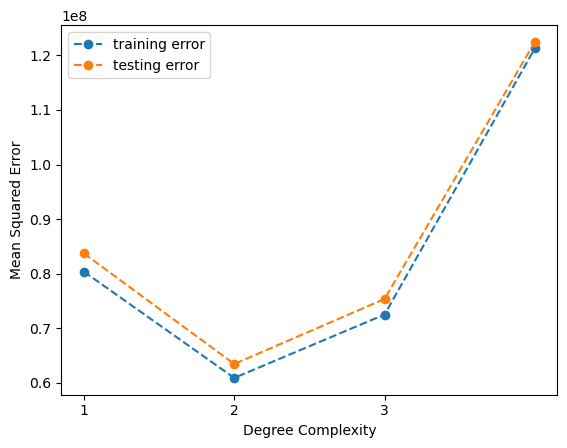

In [451]:
print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
plt.plot(range(1, 5), train_mses, '--o', label = 'training error')
plt.plot(range(1, 5), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, 4), range(1, 4))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

<label style="color:Purple">Model Pipeline</label>

In [452]:
cats = ['model' , 'state', 'manufacturer', 'condition', 'fuel', 'transmission', 'drive', 'type', 'region', 'title_status', 'paint_color']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        (PolynomialFeatures(degree = degree), make_column_selector(dtype_include=np.number)),
        remainder='passthrough'
)

linear_pol_pipe = Pipeline(
    [
        ('transf', transf),
        ('stdscl', StandardScaler()),
        ('model', LinearRegression())
    ])
linear_pol_pipe

Pipeline(steps=[('transf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['model', 'state',
                                                   'manufacturer', 'condition',
                                                   'fuel', 'transmission',
                                                   'drive', 'type', 'region',
                                                   'title_status',
                                                   'paint_color']),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028C6F96E190>)])),
                ('stdscl', StandardScaler()), ('model', LinearRegression())])

<label style="color:Purple">Model Fitting</label>

In [453]:
linear_pol_pipe.fit(X_train, y_train)

Pipeline(steps=[('transf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['model', 'state',
                                                   'manufacturer', 'condition',
                                                   'fuel', 'transmission',
                                                   'drive', 'type', 'region',
                                                   'title_status',
                                                   'paint_color']),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028C6F96E190>)])),
                ('stdscl', StandardScaler()), ('model', LinearRegression())])

<label style="color:Purple">Model Error</label>

In [454]:
y_train_predict = linear_pol_pipe.predict(X_train).astype(int)
y_test_predict = linear_pol_pipe.predict(X_test).astype(int)

train_mse = mean_squared_error(y_train, y_train_predict)
test_mse = mean_squared_error(y_test, y_test_predict)
train_r2 = r2_score(y_train, y_train_predict)
test_r2 = r2_score(y_test, y_test_predict)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

results = pd.concat([
    results, pd.DataFrame({
        'Model':'Linear Regression with Polynomial', 
        'MSE Training': train_mse, 
        'MSE Dev': test_mse,
        'R2 Training': train_r2,
        'R2 Dev': test_r2,
        'Degree': 'NA', 
        'Alpha': 'NA', 
        'Features': 'All'
    }, index=[1])])

Train MSE: 60901987.96323551
Test MSE: 63452635.43930838
Train R2: 0.6816745101617732
Test R2: 0.6695921289672103


<label style="color:Purple">Prediction Plot</label>

Pred   Real
0       27192  27600
1       22740  18988
2       26066  29995
3        4504   4200
4       -3451   3300
...       ...    ...
100050   7844    800
100051  32528  34888
100052  13268   4750
100053  16247   6900
100054  15686   6500

[100055 rows x 2 columns]

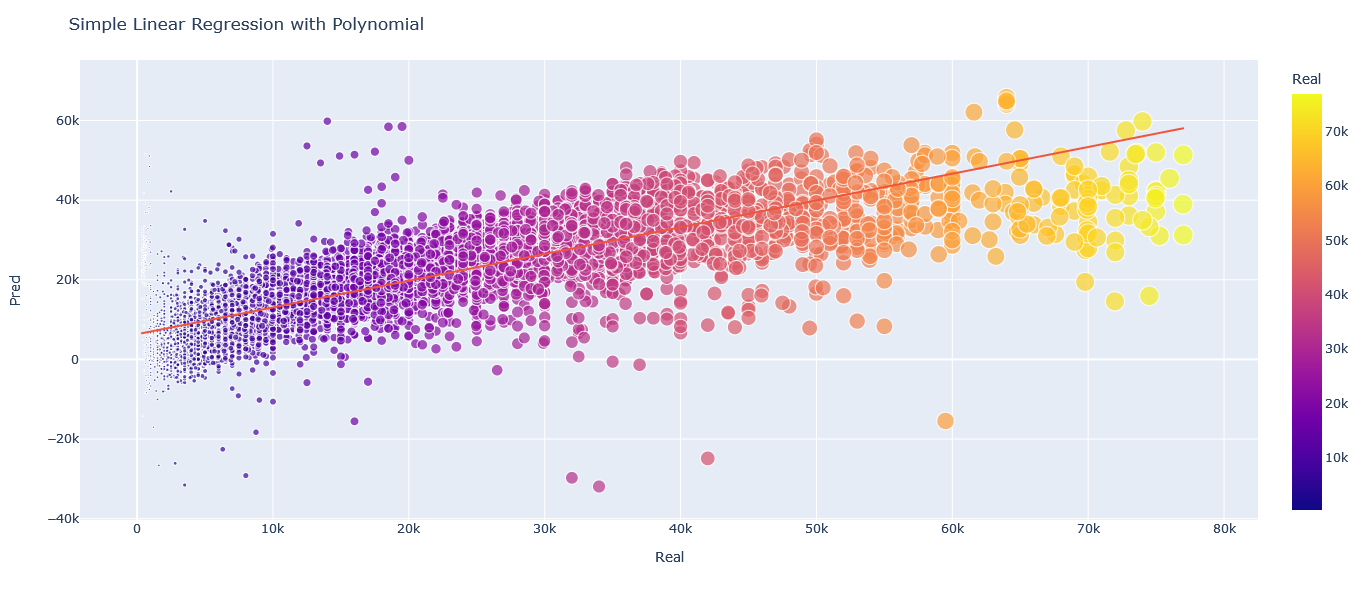

In [455]:
plot_df = pd.concat([
    pd.DataFrame(y_test_predict.reshape(len(y_test_predict), 1), 
                 columns = ['Pred']), 
    pd.DataFrame({'Real':y_test}).reset_index().drop('index', axis = 1)])

pred_df = pd.DataFrame(y_test_predict.reshape(len(y_test_predict), 1), columns = ['Pred'])
real_df = pd.DataFrame({'Real':y_test}).reset_index().drop('index', axis = 1)
plot_df = pd.concat([pred_df, real_df], axis=1)

display(plot_df)
fig = px.scatter(plot_df.loc[plot_df['Pred'] < 1000000].sample(10000),  x = 'Real', y = 'Pred', size='Real', color="Real", trendline="ols")

fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title="Simple Linear Regression with Polynomial"
)

fig.show()

<h4 style="color:Green">Ridge with Polynomial</h4>

<label style="color:Purple">Model Pipeline</label>

In [456]:
cats = ['model' , 'state', 'manufacturer', 'condition', 'fuel', 'transmission', 'drive', 'type', 'region', 'title_status', 'paint_color']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        (PolynomialFeatures(degree = degree), make_column_selector(dtype_include=np.number)),
        remainder='passthrough'
)

rid_pipe = Pipeline(
    [
        ('transf', transf),
        ('stdscl', StandardScaler()),
        ('model', Ridge())
        #('regressor', TransformedTargetRegressor(regressor = Ridge(), func=np.log10, inverse_func=exp10))
    ])
rid_pipe

Pipeline(steps=[('transf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['model', 'state',
                                                   'manufacturer', 'condition',
                                                   'fuel', 'transmission',
                                                   'drive', 'type', 'region',
                                                   'title_status',
                                                   'paint_color']),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028C6FD22590>)])),
                ('stdscl', StandardScaler()), ('model', Ridge())])

<label style="color:Purple">Model Fitting</label>

In [457]:
%%time
alpha = np.logspace(-5, 10, 10)
rid_param_dict = {'model__alpha': alpha}
rid_grid = GridSearchCV(rid_pipe, param_grid=rid_param_dict, scoring = 'neg_mean_squared_error')
rid_grid.fit(X_train, y_train)
best_estimator = rid_grid.best_estimator_

CPU times: total: 1min 52s
Wall time: 54.7 s


<label style="color:Purple">Model Error</label>

In [458]:
y_train_predict = best_estimator.predict(X_train).astype(int)
#y_train_predict = y_train_predict.astype(int)

y_test_predict = best_estimator.predict(X_test).astype(int)
#y_test_predict = y_test_predict.astype(int)

train_mse = mean_squared_error(y_train, y_train_predict)
test_mse = mean_squared_error(y_test, y_test_predict)
train_r2 = r2_score(y_train, y_train_predict)
test_r2 = r2_score(y_test, y_test_predict)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

rid_best_regressor = best_estimator.named_steps['model']
print(f'Best alpha: {rid_best_regressor.alpha}')
print(f'Score: {np.abs(rid_grid.best_score_)}')

alpha = rid_best_regressor.alpha

results = pd.concat([
    results, pd.DataFrame({
        'Model':'Ridge with Polynomial', 
        'MSE Training': train_mse, 
        'MSE Dev': test_mse,
        'R2 Training': train_r2,
        'R2 Dev': test_r2,
        'Degree': 'NA', 
        'Alpha': alpha, 
        'Features': 'All'
    }, index=[3])])
best_estimator_final = best_estimator

Train MSE: 60901983.71808755
Test MSE: 63452635.71349758
Train R2: 0.6816745323505202
Test R2: 0.6695921275394641
Best alpha: 1e-05
Score: 64440805.242050804


<label style="color:Purple">Prediction Plot</label>

In [459]:
plot_df = pd.concat([
    pd.DataFrame(y_test_predict.reshape(len(y_test_predict), 1), 
                 columns = ['Pred']), 
    pd.DataFrame({'Real':y_test}).reset_index().drop('index', axis = 1)])

pred_df = pd.DataFrame(y_test_predict.reshape(len(y_test_predict), 1), columns = ['Pred'])
real_df = pd.DataFrame({'Real':y_test}).reset_index().drop('index', axis = 1)
plot_df = pd.concat([pred_df, real_df], axis=1)

display(plot_df)
fig = px.scatter(plot_df.loc[plot_df['Pred'] < 1000000].sample(10000),  x = 'Real', y = 'Pred', size='Real', color="Real", trendline="ols")

fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title="Ridge with Polynomia"
)

fig.show()

Pred   Real
0       27192  27600
1       22740  18988
2       26066  29995
3        4504   4200
4       -3451   3300
...       ...    ...
100050   7845    800
100051  32528  34888
100052  13268   4750
100053  16247   6900
100054  15686   6500

[100055 rows x 2 columns]

<h4 style="color:Green">Lasso, SequentialFeatureSelector with Polynomial</h4>

<label style="color:Purple">Model Pipeline</label>

In [460]:
transf = make_column_transformer(
        (PolynomialFeatures(degree = degree, include_bias = False), make_column_selector(dtype_include=np.number)))
    
lasso_pol_pipe = Pipeline([('transf', transf),
                 ('selector', SequentialFeatureSelector(Lasso())),
                 ('lasmodel', Lasso())])
lasso_pol_pipe

Pipeline(steps=[('transf',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028C53C3FB90>)])),
                ('selector', SequentialFeatureSelector(estimator=Lasso())),
                ('lasmodel', Lasso())])

<label style="color:Purple">Model Fitting</label>

In [461]:
%%time
n_feat = [4,5,6]
param_dict = {'selector__n_features_to_select' : n_feat}
grid = GridSearchCV(lasso_pol_pipe, param_grid=param_dict, scoring = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
best_estimator = grid.best_estimator_

CPU times: total: 16min 11s
Wall time: 2min 31s


<label style="color:Purple">Model Error</label>

In [462]:
best_selector = best_estimator.named_steps['selector']
best_model = best_estimator.named_steps['lasmodel']
best_transf = best_estimator.named_steps['transf']

y_train_predict = best_estimator.predict(X_train).astype(int)
#y_train_predict = y_train_predict.astype(int)

y_test_predict = best_estimator.predict(X_test).astype(int)
#y_test_predict = y_test_predict.astype(int)

train_mse = mean_squared_error(y_train, y_train_predict)
test_mse = mean_squared_error(y_test, y_test_predict)
train_r2 = r2_score(y_train, y_train_predict)
test_r2 = r2_score(y_test, y_test_predict)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

print(f'Best alpha: {best_model.alpha}')
print(f'Score: {np.abs(grid.best_score_)}')

feature_names = best_transf.get_feature_names_out()[best_selector.get_support()]
display(pd.DataFrame({'Selected Columns:': [cols.replace('polynomialfeatures__', '') for cols in feature_names]}))

results = pd.concat([
    results, pd.DataFrame({
        'Model':'Lasso, SequentialFeatureSelector with Polynomial', 
        'MSE Training': train_mse, 
        'MSE Dev': test_mse,
        'R2 Training': train_r2,
        'R2 Dev': test_r2,
        'Degree': 'NA', 
        'Alpha': best_model.alpha, 
        'Features': len(feature_names)
    }, index=[3])])

Train MSE: 122980668.26880524
Test MSE: 123962668.29495777
Train R2: 0.3571986272281923
Test R2: 0.3545068532566009
Best alpha: 1.0
Score: 123031946.29579918


Selected Columns:
0              year
1         cylinders
2            year^2
3     year odometer
4       cylinders^2
5        odometer^2

<label style="color:Purple">Prediction Plot</label>

Pred   Real
0       26308  27600
1       22192  18988
2       22350  29995
3       10985   4200
4        7022   3300
...       ...    ...
100050   4370    800
100051  25979  34888
100052  12711   4750
100053  18201   6900
100054  21611   6500

[100055 rows x 2 columns]

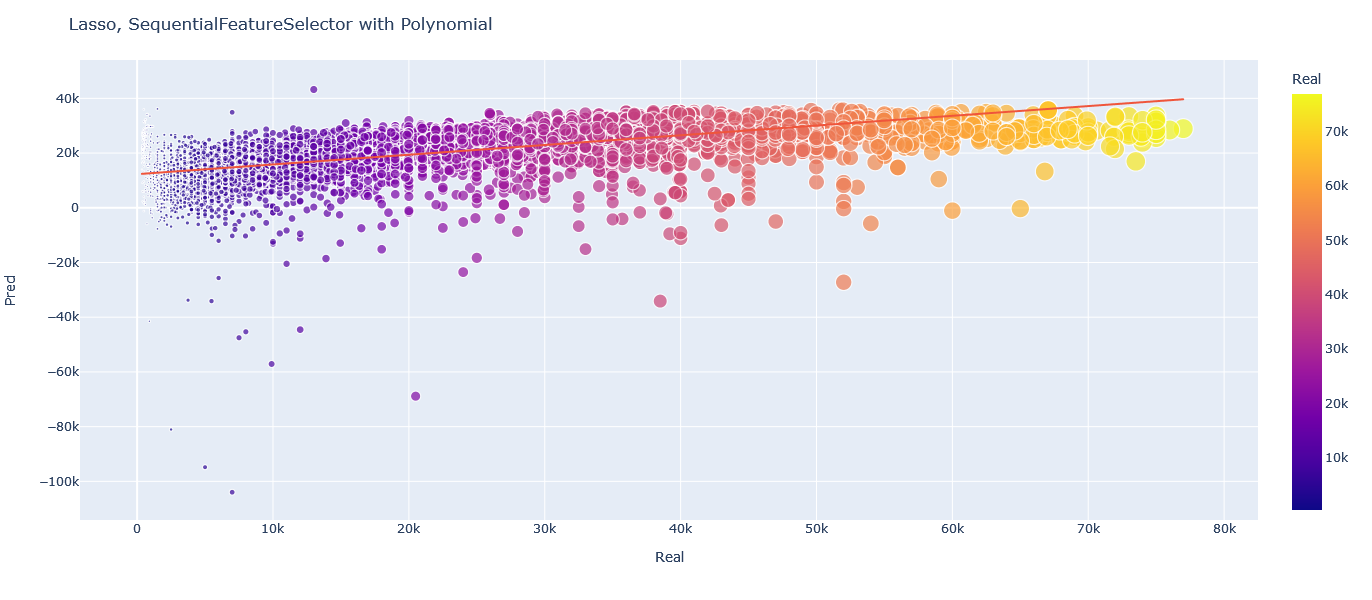

In [463]:
plot_df = pd.concat([
    pd.DataFrame(y_test_predict.reshape(len(y_test_predict), 1), 
                 columns = ['Pred']), 
    pd.DataFrame({'Real':y_test}).reset_index().drop('index', axis = 1)])

pred_df = pd.DataFrame(y_test_predict.reshape(len(y_test_predict), 1), columns = ['Pred'])
real_df = pd.DataFrame({'Real':y_test}).reset_index().drop('index', axis = 1)
plot_df = pd.concat([pred_df, real_df], axis=1)

display(plot_df)
fig = px.scatter(plot_df.loc[plot_df['Pred'] < 1000000].sample(10000),  x = 'Real', y = 'Pred', size='Real', color="Real", trendline="ols")

fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title="Lasso, SequentialFeatureSelector with Polynomial"
)

fig.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

____


<h4 style="color:Blue">Definition</h4> 

We proceed to evaluate our model to verify if it is really good at making predictions.

<h4 style="color:Blue">MSE Evaluation</h4> 

We evaluate the best MSE and best R2

In [464]:
results

Model  MSE Training  \
0                                 Linear Regression  8.036417e+07   
1                 Linear Regression with Polynomial  6.090199e+07   
3                             Ridge with Polynomial  6.090198e+07   
3  Lasso, SequentialFeatureSelector with Polynomial  1.229807e+08   

        MSE Dev  R2 Training    R2 Dev Degree    Alpha Features  
0  8.370098e+07     0.579949  0.564156     NA       NA      All  
1  6.345264e+07     0.681675  0.669592     NA       NA      All  
3  6.345264e+07     0.681675  0.669592     NA  0.00001      All  
3  1.239627e+08     0.357199  0.354507     NA      1.0        6

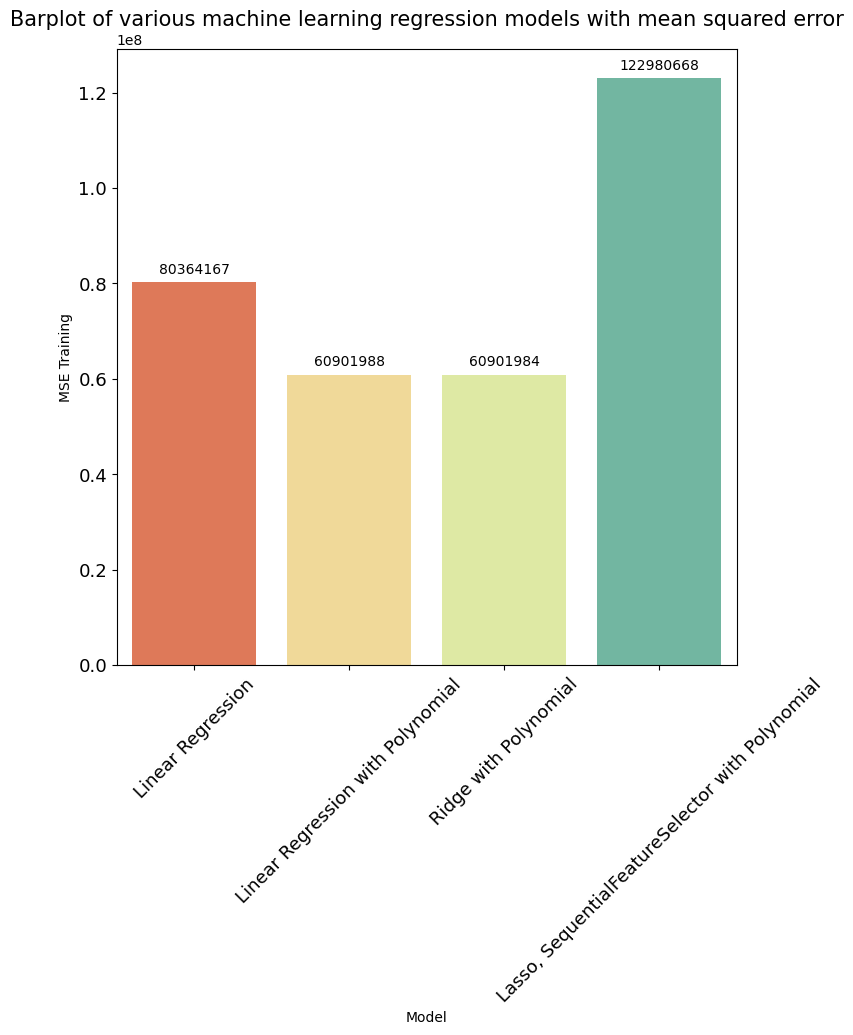

In [467]:
plt.figure(figsize = (8, 8))
fig = sns.barplot(data = results, x = 'Model', y = 'MSE Training', palette = 'Spectral')
for p in fig.patches:
    fig.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(fontsize = 13, rotation=45)
plt.yticks(fontsize = 13)
plt.title("Barplot of various machine learning regression models with mean squared error", fontsize = 15)
plt.show()

<h4 style="color:Blue">Feature Weight</h4> 

Here we look for which characteristics have a considerable weight in the price calculation, for that we will use permutation importance

In [468]:
%%time
importances = permutation_importance(best_estimator_final, X_train, y_train, n_repeats = 5, random_state=40)

CPU times: total: 22.1 s
Wall time: 22.6 s


In [469]:
importances_tr = dict(zip(X_train.columns, importances.importances_mean))
display(importances_tr)
importances_tr = {k : v for k ,v in sorted(importances_tr.items(), key = lambda x: x[1], reverse = True)}
display(importances_tr)

import_df = pd.DataFrame(importances_tr.values(), index=importances_tr.keys(), columns = ['Importances'])
display(import_df)

{'region': 0.0034969864620601364,
 'year': 0.27957850731055534,
 'manufacturer': 0.0015233034074782382,
 'model': 0.3829809453637633,
 'condition': 0.001170243365841106,
 'cylinders': 0.0149427960580794,
 'fuel': 0.030826643124048304,
 'odometer': 0.05480110517201751,
 'title_status': 0.004743014302406157,
 'transmission': 0.03287861980272646,
 'drive': 0.004490656124338166,
 'type': 0.005550812008956773,
 'paint_color': 1.913217839590864e-05,
 'state': 0.0030048704341841593}

{'model': 0.3829809453637633,
 'year': 0.27957850731055534,
 'odometer': 0.05480110517201751,
 'transmission': 0.03287861980272646,
 'fuel': 0.030826643124048304,
 'cylinders': 0.0149427960580794,
 'type': 0.005550812008956773,
 'title_status': 0.004743014302406157,
 'drive': 0.004490656124338166,
 'region': 0.0034969864620601364,
 'state': 0.0030048704341841593,
 'manufacturer': 0.0015233034074782382,
 'condition': 0.001170243365841106,
 'paint_color': 1.913217839590864e-05}

Importances
model            0.382981
year             0.279579
odometer         0.054801
transmission     0.032879
fuel             0.030827
cylinders        0.014943
type             0.005551
title_status     0.004743
drive            0.004491
region           0.003497
state            0.003005
manufacturer     0.001523
condition        0.001170
paint_color      0.000019

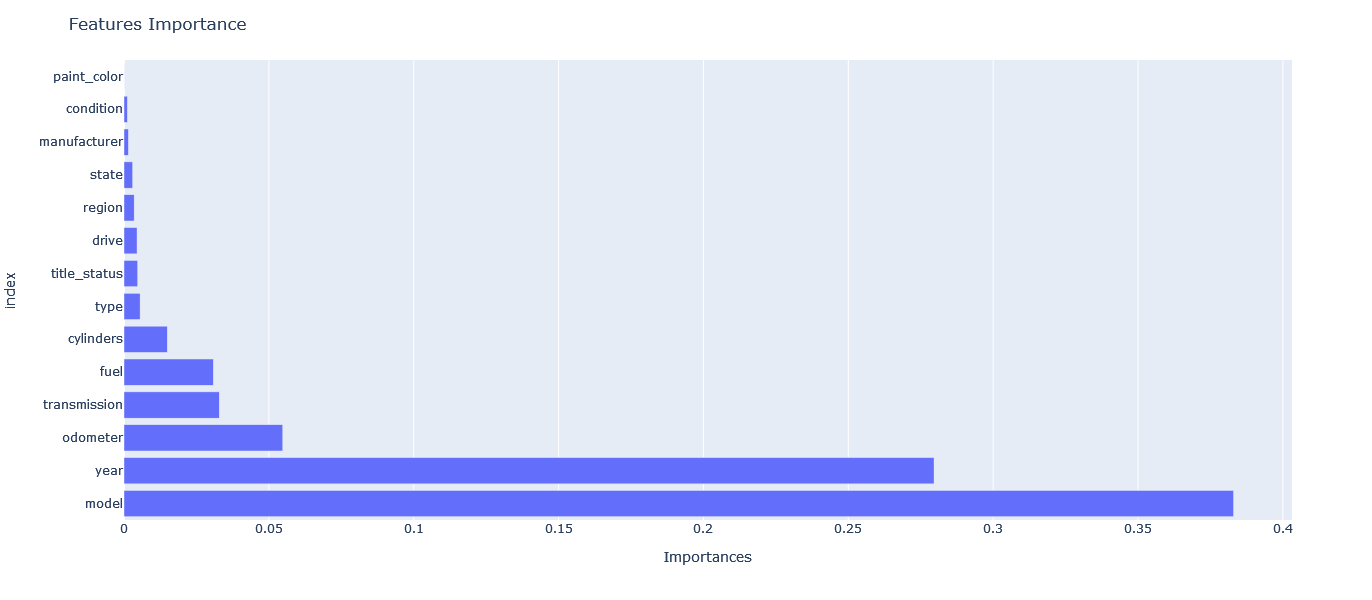

In [470]:
fig = px.bar(import_df, x="Importances")
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title="Features Importance"
)
fig.show()

In [471]:
best_scaler = best_estimator_final.named_steps['stdscl']
best_transf = best_estimator_final.named_steps['transf']
best_model = best_estimator_final.named_steps['model']
coefs = best_model.coef_
feat_names = [cols.replace('polynomialfeatures__', '').replace('targetencoder__', '') for cols in best_transf.get_feature_names_out()]

In [472]:
coefs_tr = dict(zip(feat_names, coefs))
coefs_tr = {k : v for k ,v in sorted(coefs_tr.items(), key = lambda x: x[1], reverse = True)}

coefs_df = pd.DataFrame(coefs_tr.values(), index=coefs_tr.keys(), columns = ['Coef']).reset_index().rename(columns={'index': 'Feature'})

best_transf = best_estimator_final.named_steps['transf']
X_train_preprocessed = pd.DataFrame(
    best_transf.transform(X_train)
    
)

#coefs_df['Coef'] = coefs * X_train_preprocessed.std(axis=0)
display(coefs_df)

Feature           Coef
0               year^2  553561.386998
1       year cylinders   41518.536532
2                model    6055.942061
3           odometer^2    4724.577889
4             odometer    4353.501360
5                 fuel    1720.031557
6                 type     726.656330
7         title_status     672.950080
8                drive     656.355324
9               region     577.238956
10               state     533.231780
11        manufacturer     377.824927
12           condition     332.401581
13         cylinders^2     141.795143
14         paint_color      39.742038
15                   1       0.000000
16  cylinders odometer   -1689.174476
17        transmission   -1772.157900
18       year odometer   -8022.409349
19           cylinders  -40488.299547
20                year -550972.847543

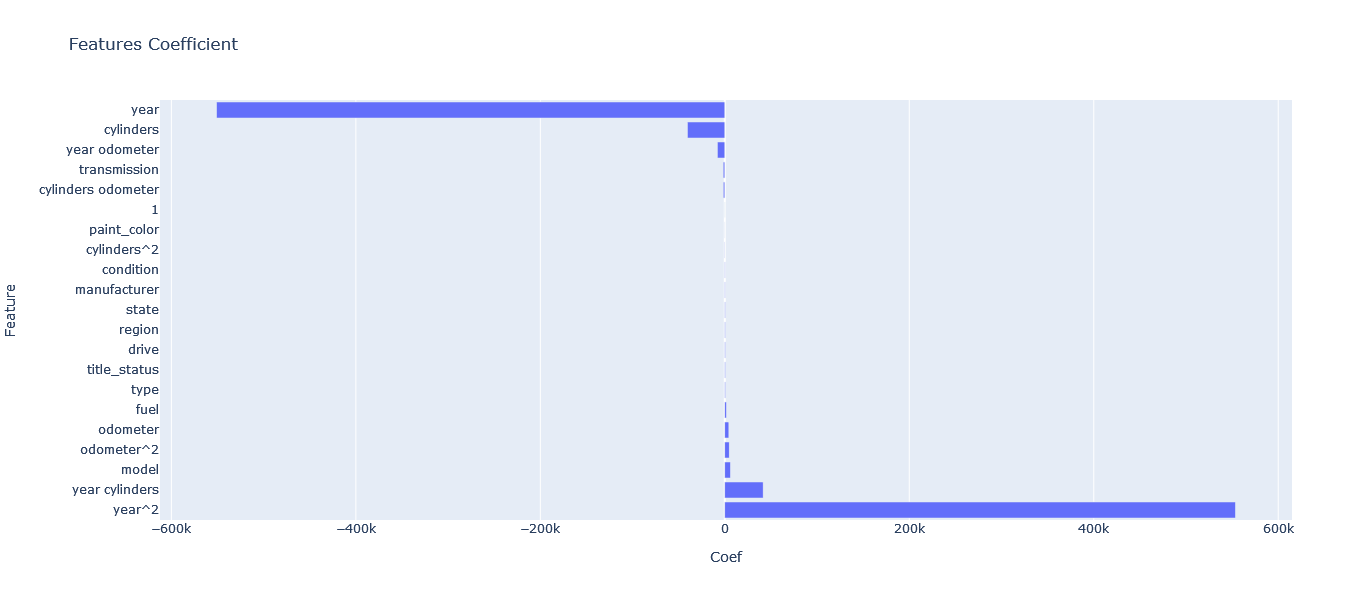

In [473]:
fig = px.bar(coefs_df, y="Feature", x="Coef", title="Gráfico de barras horizontales")
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title="Features Coefficient"
)
fig.show()

<h4 style="color:Blue">Data Analysis</h4> 

Here we start a data analysis to verify how important are the most important features with respect to price. We will use the 6 features with the most weight including manufacture

<label style="color:Purple">Average Car Price by Manufacturer</label>

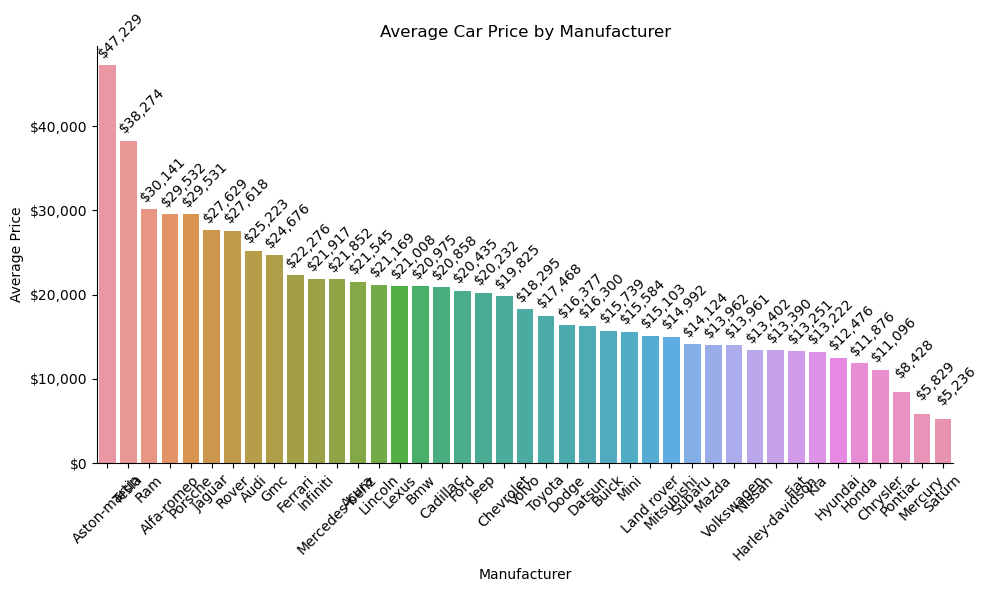

<Figure size 640x480 with 0 Axes>

In [475]:
average_price_per_manufacturer = vehicles_clean.groupby('manufacturer')['price'].mean().reset_index()

# Sort the manufacturers by average price in descending order
average_price_per_manufacturer_sorted = average_price_per_manufacturer.sort_values(by='price', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
ax = sns.barplot(data=average_price_per_manufacturer_sorted, x='manufacturer', y='price')
plt.title('Average Car Price by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

# Get current axis tick labels
xlabels = [label.get_text() for label in plt.gca().get_xticklabels()]
ylabels = [label.get_text() for label in plt.gca().get_yticklabels()]


# Format each number with commas and a dollar sign
y_formatted_numbers = [f'${int(num):,.0f}' for num in ylabels]

# Format each number with commas separating the thousands
#_formatted_numbers = ['{:,}'.format(int(num)) for num in xlabels]

# Format each number with commas and a dollar sign
y_formatted_numbers = [f'${int(num):,.0f}' for num in ylabels]

# Capitalize each label
capitalized_labels = [label.capitalize() for label in xlabels]

# Set the modified labels back on the x-axis
plt.gca().set_xticklabels(capitalized_labels)
plt.gca().set_yticklabels(y_formatted_numbers)

plt.xticks(rotation=45)  # Optional: Rotate labels to avoid overlap

# Annotate each bar with the value
for p in ax.patches:
    ax.annotate('${:,.0f}'.format(p.get_height()),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'top',
    xytext = (10, 40),
    textcoords = 'offset points',
    rotation=45)


# Despine the plot and show the final result
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig("Average Car Price by Manufacturer.png", dpi=300)

<h4 style="color:Blue">Prediction Plot</h4> 

We compare the obtained prediction vs. actual values in order to get an overview of the effectiveness of the model. For this I randomly obtain 10000 examples of the data in order to verify it with a sample of the test data.

In [ ]:
plot_df = pd.concat([
    pd.DataFrame(y_test_predict.reshape(len(y_test_predict), 1), 
                 columns = ['Pred']), 
    pd.DataFrame({'Real':y_test}).reset_index().drop('index', axis = 1)])

pred_df = pd.DataFrame(y_test_predict.reshape(len(y_test_predict), 1), columns = ['Pred'])
real_df = pd.DataFrame({'Real':y_test}).reset_index().drop('index', axis = 1)
plot_df = pd.concat([pred_df, real_df], axis=1)

display(plot_df)
fig = px.scatter(plot_df.loc[plot_df['Pred'] < 1000000].sample(10000),  x = 'Real', y = 'Pred', size='Real', color="Real", trendline="ols")

fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title="Ridge Model"
)

fig.show()

<h4 style="color:Blue">Improvement</h4> 

We will try to improve the model by removing some columns that are not so necessary and based on the importance obtained above.

In [ ]:
X = vehicles_clean.drop(['price', 'region', 'title_status', 'paint_color'], axis = 1)
y = vehicles_clean['price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
X_train

In [ ]:
cats = ['model', 'state', 'manufacturer', 'condition', 'fuel', 'transmission', 'drive', 'type']
transf = make_column_transformer(
        (PolynomialFeatures(degree = degree), make_column_selector(dtype_include=np.number)),
        (OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), cats), 
        (OneHotEncoder(handle_unknown='infrequent_if_exist', drop = 'first', sparse_output=True), cats),
        remainder='passthrough'
)

rid_pipe = Pipeline(
    [
        ('transf', transf),
        ('stdscl', StandardScaler(with_mean=False)),
        ('regressor', TransformedTargetRegressor(regressor = Ridge(), func=np.log10, inverse_func=exp10))
    ])
rid_pipe

In [ ]:
%%time
alpha = np.logspace(-5, 10, 10)
rid_param_dict = {'regressor__regressor__alpha': alpha}
rid_grid = GridSearchCV(rid_pipe, param_grid=rid_param_dict, scoring = 'neg_mean_squared_error', cv = 5)
rid_grid.fit(X_train, y_train)
rid_best_estimator = rid_grid.best_estimator_

In [ ]:
y_train_predict = rid_best_estimator.predict(X_train)
y_train_predict = y_train_predict.astype(int)
train_mse = mean_squared_error(y_train, y_train_predict)
train_mse

y_test_predict = rid_best_estimator.predict(X_test)
y_test_predict = y_test_predict.astype(int)

train_mse = mean_squared_error(y_train, y_train_predict)
test_mse = mean_squared_error(y_test, y_test_predict)
train_r2 = r2_score(y_train, y_train_predict)
test_r2 = r2_score(y_test, y_test_predict)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

rid_best_regressor = rid_best_estimator.named_steps['regressor']
print(f'Best alpha: {rid_best_regressor.regressor_.alpha}')
print(f'Score: {np.abs(rid_grid.best_score_)}')


In [ ]:
importances = permutation_importance(rid_best_estimator, X_train, y_train, n_repeats = 8, random_state=40)

In [ ]:
importances_tr = dict(zip(X_train.columns, importances.importances_mean))
display(importances_tr)
importances_tr = {k : v for k ,v in sorted(importances_tr.items(), key = lambda x: x[1], reverse = True)}
display(importances_tr)

import_df = pd.DataFrame(importances_tr.values(), index=importances_tr.keys(), columns = ['Importances'])
display(import_df)

In [ ]:
fig = px.bar(import_df, x="Importances")
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title="Features Importance"
)
fig.show()

In [ ]:
rid_best_scaler = rid_best_estimator.named_steps['stdscl']
coefs = rid_best_regressor.regressor_.coef_
feat_names = [cols.replace('onehotencoder__', '').replace('remainder__', '') for cols in X_train.columns]

In [ ]:
coefs_tr = dict(zip(feat_names, coefs))
coefs_tr = {k : v for k ,v in sorted(coefs_tr.items(), key = lambda x: x[1], reverse = True)}

coefs_df = pd.DataFrame(coefs_tr.values(), index=coefs_tr.keys(), columns = ['Coef']).reset_index().rename(columns={'index': 'Feature'})
display(coefs_df)

____

In [ ]:
X = vehicles_clean.drop(['price', 'region', 'title_status', 'paint_color'], axis = 1)
y = vehicles_clean['price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
X_train

In [ ]:
cats = ['state', 'manufacturer', 'condition', 'fuel', 'transmission', 'drive', 'type']
transf = make_column_transformer(
        (te(), cats),
        remainder='passthrough'
)

rid_pipe = Pipeline(
    [
        ('transf', transf),
        ('stdscl', StandardScaler(with_mean=False)),
        ('regressor', TransformedTargetRegressor(regressor = Ridge(), func=np.log10, inverse_func=exp10))
    ])
rid_pipe

In [ ]:
tr = transf.fit_transform(X_train.iloc[0:10000], y_train.iloc[0:10000])
tr = pd.DataFrame(tr, columns = transf.get_feature_names_out())
tr

In [ ]:
%%time
alpha = np.logspace(-5, 10, 10)
rid_param_dict = {'regressor__regressor__alpha': alpha}
rid_grid = GridSearchCV(rid_pipe, param_grid=rid_param_dict, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1)
rid_grid.fit(X_train, y_train)
rid_best_estimator = rid_grid.best_estimator_

In [ ]:
y_train_predict = rid_best_estimator.predict(X_train)
y_train_predict = y_train_predict.astype(int)
train_mse = mean_squared_error(y_train, y_train_predict)
train_mse

y_test_predict = rid_best_estimator.predict(X_test)
y_test_predict = y_test_predict.astype(int)

train_mse = mean_squared_error(y_train, y_train_predict)
test_mse = mean_squared_error(y_test, y_test_predict)
train_r2 = r2_score(y_train, y_train_predict)
test_r2 = r2_score(y_test, y_test_predict)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

rid_best_regressor = rid_best_estimator.named_steps['regressor']
print(f'Best alpha: {rid_best_regressor.regressor_.alpha}')
print(f'Score: {np.abs(rid_grid.best_score_)}')

In [ ]:
"""
for phi in range(1 , len(import_df.index) + 1):
    print(import_df.index[0:-phi])
    transf = make_column_transformer(
        (PolynomialFeatures(degree = degree), make_column_selector(dtype_include=np.number)),
        (OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), import_df.index[0:-phi]), 
        (OneHotEncoder(handle_unknown='infrequent_if_exist', drop = 'first', sparse_output=True), import_df.index[0:-phi]),
        remainder='passthrough'
    )
    
    rid_pipe = Pipeline(
    [
        ('transf', transf),
        ('stdscl', StandardScaler(with_mean=False)),
        ('regressor', TransformedTargetRegressor(regressor = Ridge(), func=np.log10, inverse_func=exp10))
    ])
    
    X_train_less = X_train[X_train.columns.intersection(import_df.index[0:-phi])]
    X_test_less = X_test[X_test.columns.intersection(import_df.index[0:-phi])]
    
    alpha = np.logspace(-5, 10, 10)
    rid_param_dict = {'regressor__regressor__alpha': alpha}
    rid_grid = GridSearchCV(rid_pipe, param_grid=rid_param_dict, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1)
    rid_grid.fit(X_train_less, y_train)
    rid_best_estimator = rid_grid.best_estimator_
    
    y_train_predict = rid_best_estimator.predict(X_train_less)
    y_train_predict = y_train_predict.astype(int)
    train_mse = mean_squared_error(y_train, y_train_predict)
    train_mse

    y_test_predict = rid_best_estimator.predict(X_test_less)
    y_test_predict = y_test_predict.astype(int)
    
    train_mse = mean_squared_error(y_train, y_train_predict)
    test_mse = mean_squared_error(y_test, y_test_predict)
    
    print(f'Train MSE: {train_mse}')
    print(f'Test MSE: {test_mse}')

    rid_best_regressor = rid_best_estimator.named_steps['regressor']
    print(f'Best alpha: {rid_best_regressor.regressor_.alpha}')
    
    #importances = permutation_importance(rid_best_estimator, X_train, y_train, n_repeats = 8, random_state=40)
 """   

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

In [ ]:
plt.matshow(vehicles_clean[['price', 'cylinders', 'odometer', 'year']].corr())
plt.show()
vehicles_clean['price', 'cylinders', 'odometer', 'year'].corr()